# Look at Big Picture

IMDB dataset for sentiment analysis -> 0 for negative, 1 for positive

In [1]:
#from google.colab import drive
from google.colab import files
uploaded=files.upload()
#drive.mount('/content/drive')

Saving movie.csv to movie.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [3]:
# to use DL
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)

# Get the Data

## Download the Data

In [ ]:
# downloaded from kaggle

## Take a Quick Look at Data

In [4]:
dataset = pd.read_csv('movie.csv')

In [5]:
dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [7]:
# check for null values
dataset.isnull().sum()

,0
text,0
label,0


In [8]:
# check for duplicates
dataset.duplicated().sum()

np.int64(277)

In [9]:
# remove duplicates
dataset = dataset.drop_duplicates()

In [10]:
# distinct values in label and its count
dataset['label'].value_counts()

,count
label,
1,19908
0,19815


In [11]:
# both are nearly equal so accuracy is a good metric

## Create Train, Validation and Test Sets

In [12]:
from sklearn.model_selection import train_test_split


X = dataset['text']
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
X_train.shape

(23833,)

In [14]:
X_valid.shape

(7945,)

In [15]:
X_test.shape

(7945,)

# Discovering & Visualizing Data

## Visualizing Data

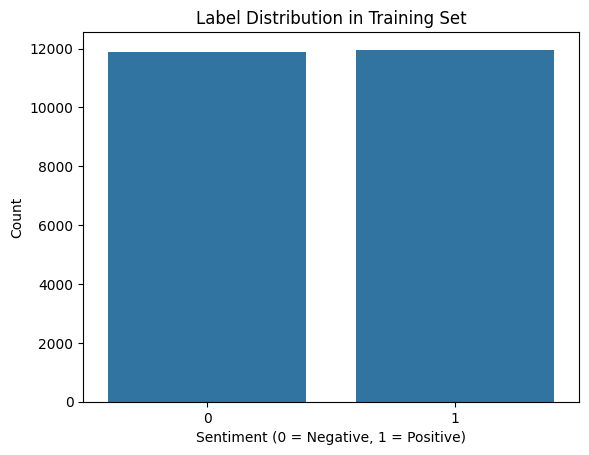

In [16]:
# Bar plot of label counts in training set
sns.countplot(x=y_train)
plt.title("Label Distribution in Training Set")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()

In [17]:
from collections import Counter
import re

# Combine all text in X_train
all_text = ' '.join(X_train)

# Tokenize: remove non-alphabetic characters and lowercase everything
words = re.findall(r'\b[a-z]+\b', all_text.lower())

# Count word frequencies
word_freq = Counter(words)

In [18]:
# Get the top 20 most common words
words_rep = 20
most_common_words = word_freq.most_common(words_rep)

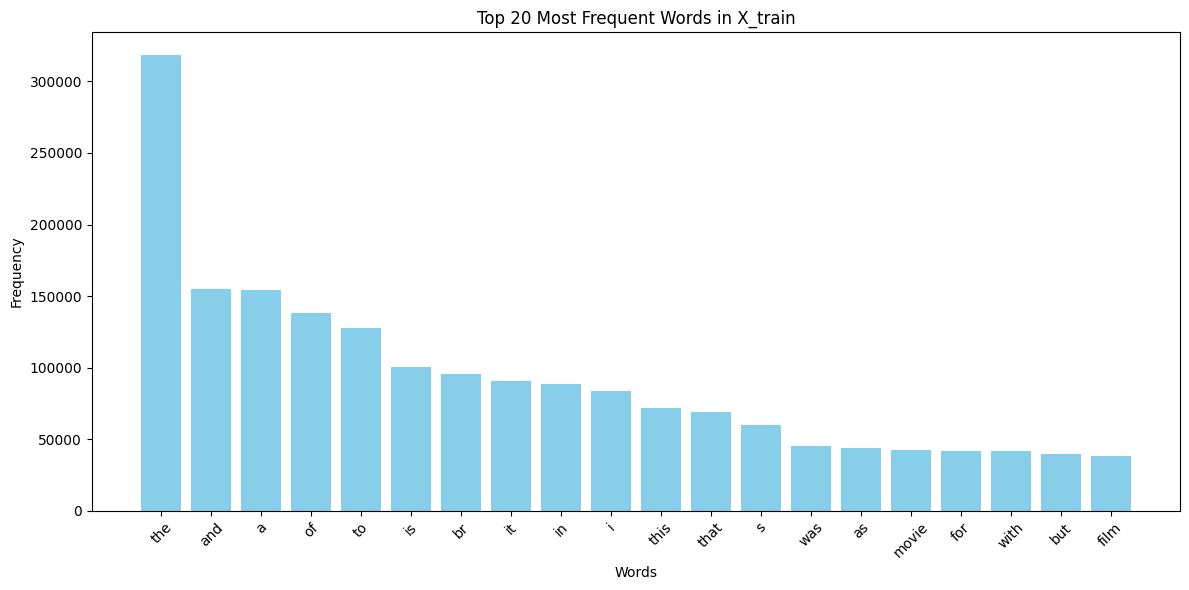

In [19]:
# Bar Chart
words_bar, freqs_bar = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words_bar, freqs_bar, color='skyblue')
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in X_train')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

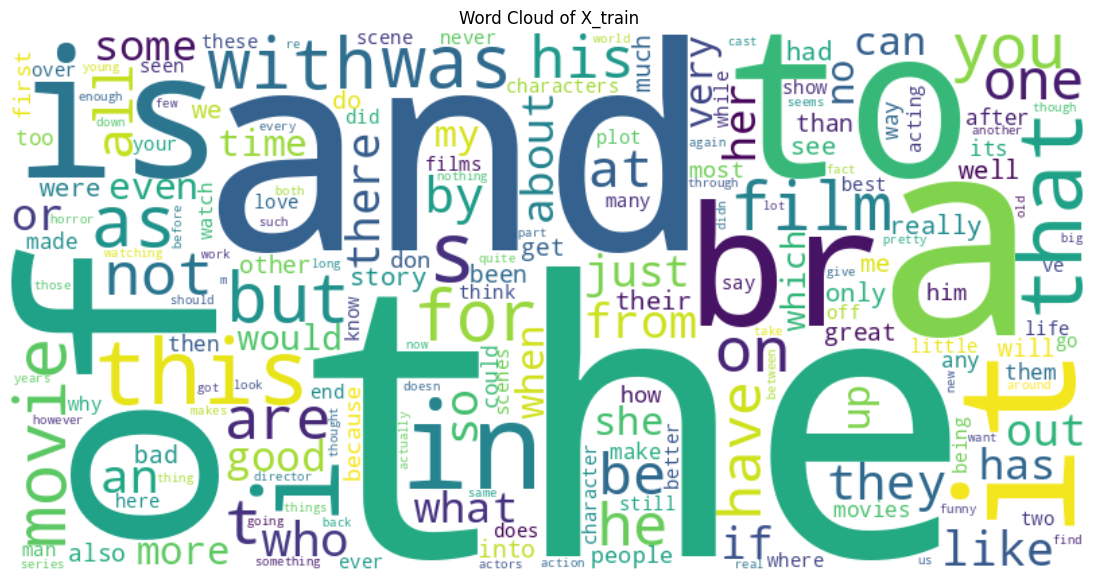

In [20]:
# Word Cloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of X_train')
plt.show()

In [21]:
# lets see non stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

filtered_words = [word for word in words if word not in stop_words]
word_freq = Counter(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
most_common_words = word_freq.most_common(words_rep)

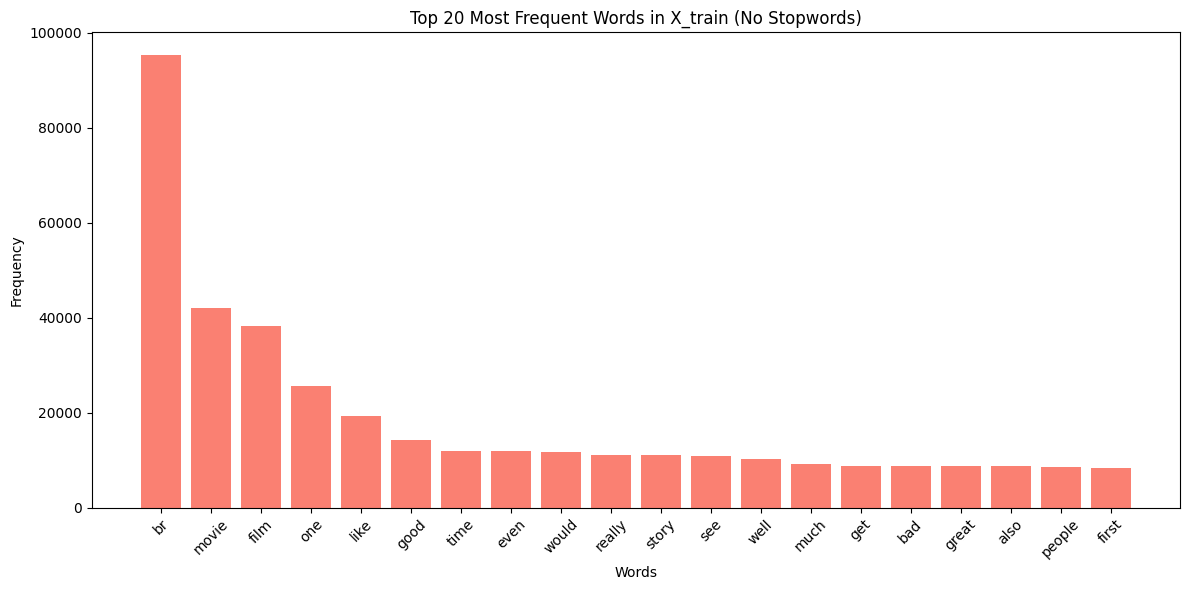

In [23]:
# Bar chart
words_bar, freqs_bar = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words_bar, freqs_bar, color='salmon')
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in X_train (No Stopwords)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

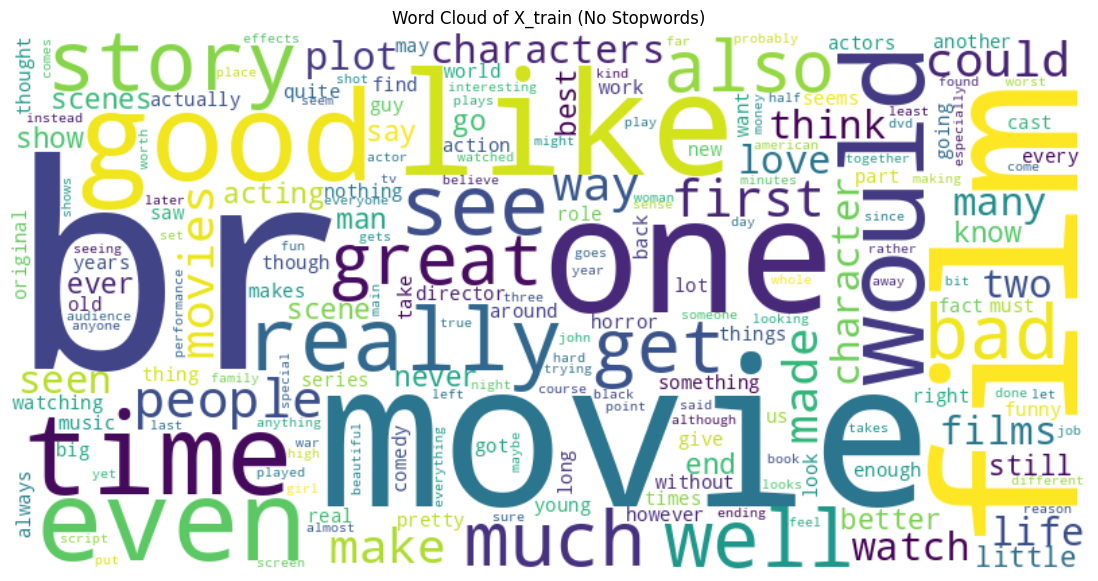

In [24]:
# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of X_train (No Stopwords)')
plt.show()

# Prepare Data for ML Algorithm

## Data Cleaning

In [ ]:
# not req.

## Handling Text Attributes

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from bs4 import BeautifulSoup
import re

class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self._clean_text)

    def _clean_text(self, text):
        # Remove HTML
        text = BeautifulSoup(text, "html.parser").get_text()
        # Lowercase
        text = text.lower()
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

In [26]:
cleaner = TextCleaner()

X_train_clean = cleaner.transform(X_train)
X_valid_clean = cleaner.transform(X_valid)
X_test_clean  = cleaner.transform(X_test)

In [ ]:
# we will use embedding layer after applying transformation

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_valid_seq = tokenizer.texts_to_sequences(X_valid_clean)
X_test_seq  = tokenizer.texts_to_sequences(X_test_clean)

In [28]:
# Pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

In [29]:
sample = 'i like the movie so much <br> it is excallent'

# Step 1: Clean the text
sample_cleaned = cleaner.transform(pd.Series([sample]))[0]

# Step 2: Tokenize
sample_seq = tokenizer.texts_to_sequences([sample_cleaned])[0]

# Step 3: Pad
sample_pad = pad_sequences([sample_seq], maxlen=200, padding='post', truncating='post')[0]

# Output
print("🔹 Original:", sample)
print("🔹 Cleaned:", sample_cleaned)
print("🔹 Tokenized:", sample_seq)
print("🔹 Padded:", sample_pad)

🔹 Original: i like the movie so much <br> it is excallent
🔹 Cleaned: i like the movie so much it is excallent
🔹 Tokenized: [11, 38, 2, 17, 36, 72, 10, 7, 1]
🔹 Padded: [11 38  2 17 36 72 10  7  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


## Feature Scaling

In [ ]:
# no feature scaling required

## Final Data

In [ ]:
# final data for ml model is in X_train_pad, X_valid_pad, X_test_pad

# Train a Model

## Create Embedding Layer

In [31]:
from google.colab import files
uploaded=files.upload()

Saving glove.6B.50d.txt to glove.6B.50d.txt


In [32]:
# Use glove.6B.50d.txt (50-dimensional vectors)

embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [33]:
# embedding matrix
embedding_dim = 50
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [34]:
from keras.layers import Embedding

embeddings = Embedding(input_dim=num_words, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=200)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Create & Train a Model

In [35]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    embeddings,
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

# Freeze the embedding layer
model.layers[0].trainable = False

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=1e-4),
              metrics=['accuracy'])

In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_valid_pad, y_valid),
                    epochs=10, batch_size=32,
                    callbacks=[early_stop, checkpoint])

Epoch 1/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.5052 - loss: 0.7003 - val_accuracy: 0.6651 - val_loss: 0.6433
Epoch 2/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.6890 - loss: 0.6109 - val_accuracy: 0.7468 - val_loss: 0.5237
Epoch 3/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 61s 82ms/step - accuracy: 0.7355 - loss: 0.5422 - val_accuracy: 0.7644 - val_loss: 0.4891
Epoch 4/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 61s 82ms/step - accuracy: 0.7522 - loss: 0.5127 - val_accuracy: 0.7742 - val_loss: 0.4714
Epoch 5/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.7680 - loss: 0.4874 - val_accuracy: 0.7897 - val_loss: 0.4550
Epoch 6/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step - accuracy: 0.7808 - loss: 0.4679 - val_accuracy: 0.7967 - val_loss: 0.4388
Epoch 7/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 66s 89ms/step - accuracy: 0.7915 - loss: 0.4545 - val_accuracy: 0.8053 - val_loss: 0.4324
Epoch 8/10
745/745 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.7974 - loss: 0.4411 - 

In [39]:
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_valid_pad, y_valid),
                    epochs=20, batch_size=32,
                    callbacks=[early_stop, checkpoint])

Epoch 1/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.8151 - loss: 0.4134 - val_accuracy: 0.8200 - val_loss: 0.4189
Epoch 2/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 85s 88ms/step - accuracy: 0.8191 - loss: 0.4065 - val_accuracy: 0.8208 - val_loss: 0.4187
Epoch 3/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.8236 - loss: 0.4012 - val_accuracy: 0.8235 - val_loss: 0.4121
Epoch 4/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.8266 - loss: 0.3977 - val_accuracy: 0.8228 - val_loss: 0.4148
Epoch 5/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.8291 - loss: 0.3927 - val_accuracy: 0.8239 - val_loss: 0.4078
Epoch 6/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 66s 89ms/step - accuracy: 0.8321 - loss: 0.3880 - val_accuracy: 0.8257 - val_loss: 0.4118
Epoch 7/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.8324 - loss: 0.3843 - val_accuracy: 0.8264 - val_loss: 0.4109
Epoch 8/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.8350 - loss: 0.3802 - 

In [40]:
from keras.models import load_model

model = load_model('best_model.keras')

In [41]:
# lets unfreeze embegging layer
model.layers[0].trainable = True

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
# lets train our final model for other 10 epochs
history = model.fit(X_train_pad, y_train,
                      validation_data=(X_valid_pad, y_valid),
                      epochs=10, batch_size=32,
                      callbacks=[early_stop, checkpoint])

In [47]:
# load best model
model = load_model('best_model.keras')

# Evaluate Test Set

In [48]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)

print(f"\n Test Accuracy: {test_accuracy:.4f}")
print(f" Test Loss: {test_loss:.4f}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8562 - loss: 0.3537

 Test Accuracy: 0.8546
 Test Loss: 0.3532


In [57]:
MAX_LEN = 100  # or whatever value you used earlier for padding


In [ ]:
# Function to preprocess user input and make prediction
def predict_sentiment(text):
    # Convert text to sequence using the same tokenizer
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    # Predict
    prediction = model.predict(padded)[0][0]  # assuming binary classification
    sentiment = "Positive 😀" if prediction > 0.5 else "Negative 😞"

    print(f"\nInput: {text}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {prediction:.2f})")

# Ask user for input
user_input = input("Enter a movie review: ")
predict_sentiment(user_input)
